In [3]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import json

# Importing the data

In [4]:
candid13 = pd.read_csv("candid13.csv", index_col=0) # data of candidates in 2013 elections
candid18 = pd.read_csv("candid18.csv", index_col=0) # data of candidates in 2018 elections
candid18post = pd.read_csv("candid18_post.csv", index_col=0) # data of candidates in 2018 elections after considering bye elections
candid23 = pd.read_csv("candid23.csv", index_col=0) # data of candidates in 2023 elections

const13 = pd.read_csv("const13.csv", index_col=0) # data of constituencies in 2013 elections
const18 = pd.read_csv("const18.csv", index_col=0) # data of constituencies in 2018 elections
const18post = pd.read_csv("const18_post.csv", index_col=0) # data of constituencies in 2018 elections after considering bye elections
const23 = pd.read_csv("const23.csv", index_col=0) # data of constituencies in 2023 elections

constnum = pd.read_csv("const_num.csv", index_col=0) # mapping of constituency number to constituency name

votemargins = pd.read_csv("votemargins.csv", index_col=0) # data of vote margins
voter_turnout = pd.read_csv("voter_turnout.csv") # data of voter turnout

# Load GeoJSON file for Karnataka constituencies
with open('output.json', 'r', encoding='utf-8') as f:
    geojson = json.load(f)

## Basic Parliament Seats Data

# Creating Plots

In [15]:
def get_total_voteshare_percent():   
    def process_year(candid_df, const_df, year):
        # Create a copy to avoid modifying the original DataFrame
        temp = candid_df.copy()
        
        # Calculate the total votes across all parties
        temp['total votes'] = temp['votes'].sum()
        
        # Group by party and total votes to calculate party totals
        grouped = temp.groupby(['party', 'total votes'])['votes'].sum().reset_index()
        grouped = grouped.rename(columns={'votes': 'party_total'})
        
        # Calculate vote share percentage
        grouped['vote share percent'] = (grouped['party_total'] / grouped['total votes']) * 100
        grouped['vote share percent'] = grouped['vote share percent'].round(2)
        
        # Add the election year
        grouped['year'] = year
        
        # Filter for specific parties
        grouped = grouped[grouped['party'].isin(['BJP', 'INC', 'JD(S)'])]
        
        # Calculate the number of constituencies won by each party
        constituencies_won = const_df.groupby('party').size().reset_index(name='constituencies won')
        
        # Merge the party totals with constituencies won
        result = pd.merge(grouped, constituencies_won, on='party')
        
        return result

    # Process data for each election year
    result13 = process_year(candid13, const13, 2013)
    result18 = process_year(candid18, const18, 2018)
    result23 = process_year(candid23, const23, 2023)

    # Combine the results from all years
    final_result = pd.concat([result13, result18, result23], ignore_index=True)
    return final_result

In [16]:
get_total_voteshare_percent()

,party,total votes,party_total,vote share percent,year,constituencies won
0,BJP,30694374.0,6231660.0,20.30,2013,40
1,INC,30694374.0,11254487.0,36.67,2013,122
2,JD(S),30694374.0,6091769.0,19.85,2013,40
3,BJP,35930149.0,13297224.0,37.01,2018,104
4,INC,35930149.0,13652276.0,38.00,2018,80
5,JD(S),35930149.0,6723011.0,18.71,2018,37
6,BJP,38823869.0,14210103.0,36.60,2023,66
7,INC,38823869.0,16616300.0,42.80,2023,135
8,JD(S),38823869.0,5268788.0,13.57,2023,19


## Karnataka's Electoral History

In [27]:
# Define the list of major parties and their corresponding colors
major_parties = ['BJP', 'INC', 'JD(S)']
party_colors = {
    'BJP': '#FF7500',
    'INC': '#0D5BE1',
    'JD(S)': 'green'
}

# Define the years
years = [2013, 2018, 2023]

# Candidate dataframes for each year (assumed to be already loaded)
candid_dfs = {
    2013: candid13,
    2018: candid18,
    2023: candid23
}

# Constituency dataframes for each year (assumed to be already loaded)
const_dfs = {
    2013: const13,
    2018: const18,
    2023: const23
}


### Plot 1: Vote Share Percent by Major Party and Year

In [49]:
# Prepare the data for vote share percentages
vote_share_data = []

for year in years:
    candid_df = candid_dfs[year]
    
    # Calculate total votes cast in the election
    total_votes = candid_df['votes'].sum()
    
    # Calculate total votes received by each party
    votes_by_party = candid_df.groupby('party')['votes'].sum().reset_index()
    
    # Filter for major parties
    votes_by_party = votes_by_party[votes_by_party['party'].isin(major_parties)]
    
    # Calculate vote share percentage
    votes_by_party['vote_share_percent'] = (votes_by_party['votes'] / total_votes) * 100
    
    # Add the year information
    votes_by_party['year'] = str(year)  # Convert year to string for categorical x-axis
    
    # Append to the list
    vote_share_data.append(votes_by_party[['year', 'party', 'vote_share_percent']])

# Combine the data for all years into a single dataframe
vote_share_df = pd.concat(vote_share_data, ignore_index=True)

# Create the plot for vote share percentages
fig_vote_share = px.bar(
    vote_share_df,
    x='year',
    y='vote_share_percent',
    color='party',
    barmode='group',
    labels={'vote_share_percent': 'Vote Share (%)', 'year': 'Year', 'party': 'Party'},
    color_discrete_map=party_colors,
    custom_data=['party'],
)

fig_vote_share.update_traces(
    hovertemplate="Year: %{x}<br>Vote Share: %{y:.2f}%<br>Party: %{customdata[0]}<extra></extra>"
)

# Update layout as per your specifications
fig_vote_share.update_layout(
    # font=dict(family='Cambria'),
    bargap=0.6,  # Adjust the gap between bars
    bargroupgap=0.2,
    dragmode = False,
    xaxis=dict(
        title='Year',
        tickmode='linear',
        showgrid=False,
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black")
    ),
    yaxis=dict(
        title='Vote Share (%)',
        gridcolor='lightgrey',
        showgrid=True,
        zeroline=True,
        tickvals = [0,5,10,15,20,25,30,35,40,45,50],
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black")
    ),
    title = dict(
        font=dict(family="Cambria", size=18, color="black"),
        text = "Vote Share (%) of Major Parties over the years",
        xanchor = 'center',
        x = 0.5
    ),
    margin = dict(pad=10,t=70,b=70,r=70,l=70), 
    legend_title_font=dict(family="Cambria", size=14, color="black"),
    legend_font=dict(family="Cambria", size=13, color="black"),
    legend_title_text='Party',
    plot_bgcolor='#f8f8f8',
    paper_bgcolor='#f8f8f8',
    autosize=True,
)

# Only show horizontal gridlines
fig_vote_share.update_xaxes(showgrid=False)
fig_vote_share.update_yaxes(showgrid=True)

# Save the figure as JSON
pio.write_json(fig_vote_share, 'plots/keh_voteshare.json')
fig_vote_share


### Plot 2: Constituencies Won by Major Parties by Year

In [34]:
# Prepare the data for constituencies won
seats_won_data = []

for year in years:
    const_df = const_dfs[year]
    
    # Calculate the number of constituencies won by each party
    seats_won = const_df['party'].value_counts().reset_index()
    seats_won.columns = ['party', 'seats_won']
    
    # Filter for major parties
    seats_won = seats_won[seats_won['party'].isin(major_parties)]
    
    # Add the year information
    seats_won['year'] = str(year)  # Convert year to string for categorical x-axis
    
    # Append to the list
    seats_won_data.append(seats_won[['year', 'party', 'seats_won']])

# Combine the data for all years into a single dataframe
seats_won_df = pd.concat(seats_won_data, ignore_index=True)

# Create the plot for constituencies won
fig_seats_won = px.bar(
    seats_won_df,
    x='year',
    y='seats_won',
    color='party',
    barmode='group',
    labels={'seats_won': 'Constituencies Won', 'year': 'Year', 'party': 'Party'},
    color_discrete_map=party_colors,
    custom_data=['party'],
)

fig_vote_share.update_traces(
    hovertemplate="Year: %{x}<br>Constituencies Won: %{y}%<br>Party: %{customdata[0]}<extra></extra>"
)

# Update layout as per your specifications
fig_seats_won.update_layout(
    bargap=0.6,
    bargroupgap=0.2,
    dragmode = False,
    xaxis=dict(
        title='Year',
        tickmode='linear',
        showgrid=False,
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black")
    ),
    yaxis=dict(
        title='Constituencies Won',
        gridcolor='lightgrey',
        showgrid=True,
        zeroline=True,
        tickvals = [0,20,40,60,80,100,120,140],
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black")
    ),
    title = dict(
        font=dict(family="Cambria", size=18, color="black"),
        text = "Constituencies Won by Major Parties over the years",
        xanchor = 'center',
        x = 0.5
    ),
    margin = dict(pad=10,t=70,b=70,l=70,r=70), 
    legend_title_font=dict(family="Cambria", size=14, color="black"),
    legend_font=dict(family="Cambria", size=13, color="black"),
    legend_title_text='Party',
    plot_bgcolor='#f8f8f8',
    paper_bgcolor='#f8f8f8',
    autosize=True,
)

# Only show horizontal gridlines
fig_seats_won.update_xaxes(showgrid=False)
fig_seats_won.update_yaxes(showgrid=True)

# Save the figure as JSON
pio.write_json(fig_seats_won, 'plots/keh_constwon.json')
fig_seats_won

### Seats won vs Popular Vote analysis for 2018 election

In [ ]:
for col in votemargins.columns:
    print(col)

Year
const_num
constituency
total_const_votes
winner_name
winner_party
winner_votes
runner_name
runner_party
runner_votes
vote_difference
margin_percent


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
votemargins = pd.read_csv("votemargins.csv", index_col=0) # data of vote margins
votemargins = votemargins.loc[votemargins['Year']==2018, ['const_num', 'constituency', 'total_const_votes', 'winner_party', 'winner_votes', 'runner_party', 'runner_votes', 'vote_difference', 'margin_percent']].copy()

In [ ]:
# votemargins = votemargins.loc[votemargins['winner_party'].isin(['BJP']) & votemargins['runner_party'].isin(['INC'])].copy()
votemargins

,const_num,constituency,total_const_votes,winner_party,winner_votes,runner_party,runner_votes,vote_difference,margin_percent
224,1,Nippani,172251,BJP,87006,INC,78500,8506,4.938143
225,2,Chikkodi-Sadalga,179202,INC,91467,BJP,80898,10569,5.897814
226,3,Athani,170565,INC,82094,BJP,79763,2331,1.366634
227,4,Kagwad,145735,INC,83060,BJP,50118,32942,22.604042
228,5,Kudachi,136654,BJP,67781,INC,52773,15008,10.982481
...,...,...,...,...,...,...,...,...,...
442,220,T.Narasipur,155286,JD(S),83929,INC,55451,28478,18.339065
443,221,Hanur,170333,INC,60444,BJP,56931,3513,2.062431
444,222,Kollegal,168871,BSP,71792,INC,52338,19454,11.520036
445,223,Chamarajanagar,167111,INC,75963,BJP,71050,4913,2.939962


In [ ]:
# Filter constituencies won by INC
inc_wins = votemargins[votemargins['winner_party'] == 'INC']

# Calculate average vote difference and margin percent
inc_avg_vote_diff = inc_wins['vote_difference'].mean()
inc_avg_margin_percent = inc_wins['margin_percent'].mean()

print(f"INC Average Vote Margin: {inc_avg_vote_diff:.2f}")
print(f"INC Average Margin Percent: {inc_avg_margin_percent:.2f}%")


INC Average Vote Margin: 15943.84
INC Average Margin Percent: 10.00%


In [ ]:
# Filter constituencies won by BJP
bjp_wins = votemargins[votemargins['winner_party'] == 'BJP']

# Calculate average vote difference and margin percent
bjp_avg_vote_diff = bjp_wins['vote_difference'].mean()
bjp_avg_margin_percent = bjp_wins['margin_percent'].mean()

print(f"BJP Average Vote Margin: {bjp_avg_vote_diff:.2f}")
print(f"BJP Average Margin Percent: {bjp_avg_margin_percent:.2f}%")


BJP Average Vote Margin: 18959.56
BJP Average Margin Percent: 11.78%


In [ ]:
margin_diff = inc_avg_vote_diff - bjp_avg_vote_diff
margin_percent_diff = inc_avg_margin_percent - bjp_avg_margin_percent

print(f"Difference in Average Vote Margin (INC - BJP): {margin_diff:.2f}")
print(f"Difference in Average Margin Percent (INC - BJP): {margin_percent_diff:.2f}%")


Difference in Average Vote Margin (INC - BJP): -3015.72
Difference in Average Margin Percent (INC - BJP): -1.78%


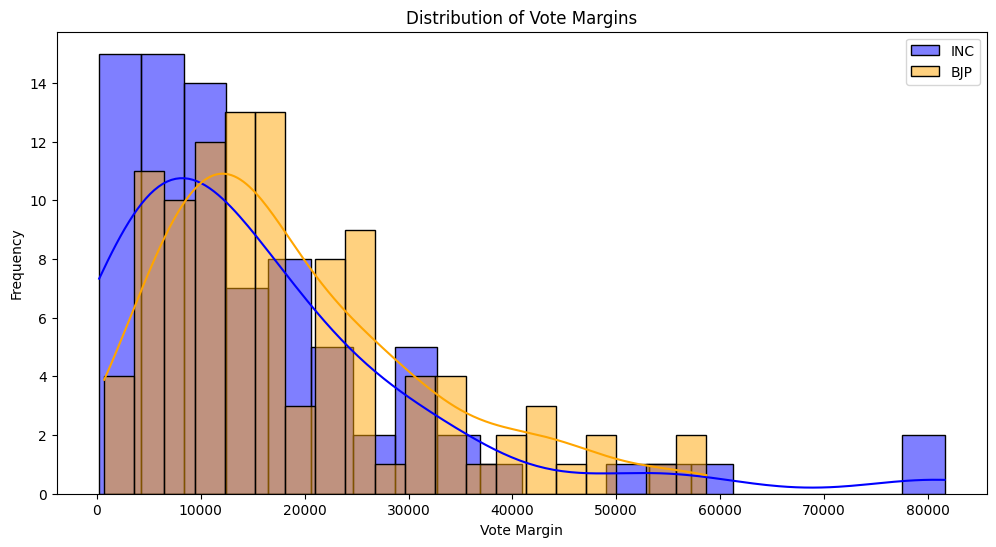

In [ ]:
plt.figure(figsize=(12, 6))
sns.histplot(inc_wins['vote_difference'], color='blue', label='INC', kde=True, bins=20)
sns.histplot(bjp_wins['vote_difference'], color='orange', label='BJP', kde=True, bins=20)
plt.title('Distribution of Vote Margins')
plt.xlabel('Vote Margin')
plt.ylabel('Frequency')
plt.legend()
plt.show()


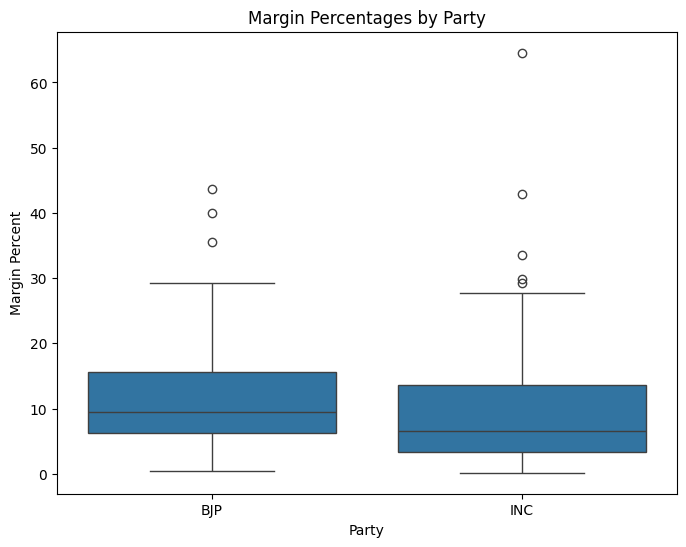

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='winner_party', y='margin_percent', data=votemargins[votemargins['winner_party'].isin(['INC', 'BJP'])])
plt.title('Margin Percentages by Party')
plt.xlabel('Party')
plt.ylabel('Margin Percent')
plt.show()

In [ ]:
# Constituencies where INC lost
inc_losses = votemargins[(votemargins['winner_party'] != 'INC') & (votemargins['runner_party'] == 'INC')]

# Average votes secured by INC in losses
inc_avg_votes_in_losses = inc_losses['runner_votes'].mean()

print(f"INC Average Votes in Lost Constituencies: {inc_avg_votes_in_losses:.2f}")


INC Average Votes in Lost Constituencies: 62116.88


In [ ]:
# Constituencies where BJP lost
bjp_losses = votemargins[(votemargins['winner_party'] != 'BJP') & (votemargins['runner_party'] == 'BJP')]

# Average votes secured by BJP in losses
bjp_avg_votes_in_losses = bjp_losses['runner_votes'].mean()

print(f"BJP Average Votes in Lost Constituencies: {bjp_avg_votes_in_losses:.2f}")


BJP Average Votes in Lost Constituencies: 61366.94


In [ ]:
votes_in_losses_diff = inc_avg_votes_in_losses - bjp_avg_votes_in_losses

print(f"Difference in Average Votes in Losses (INC - BJP): {votes_in_losses_diff:.2f}")


Difference in Average Votes in Losses (INC - BJP): 749.93


In [ ]:
# Total votes secured by INC
inc_total_votes = inc_wins['winner_votes'].sum() + inc_losses['runner_votes'].sum()

# Total votes secured by BJP
bjp_total_votes = bjp_wins['winner_votes'].sum() + bjp_losses['runner_votes'].sum()

print(f"Total Votes Secured by INC: {inc_total_votes}")
print(f"Total Votes Secured by BJP: {bjp_total_votes}")


Total Votes Secured by INC: 13009659
Total Votes Secured by BJP: 12306579


In [ ]:
total_votes_polled = votemargins['total_const_votes'].sum()


In [ ]:
inc_vote_share_calculated = (inc_total_votes / total_votes_polled) * 100
bjp_vote_share_calculated = (bjp_total_votes / total_votes_polled) * 100

print(f"INC Vote Share: {inc_vote_share_calculated:.2f}%")
print(f"BJP Vote Share: {bjp_vote_share_calculated:.2f}%")


INC Vote Share: 35.52%
BJP Vote Share: 33.60%


## Bharat Jodo Yatra

### Maps plots

In [ ]:
# Color mapping for parties
party_colors = {
    'INC': '#0D5BE1',
    'BJP': '#FF7500',
    'IND': 'grey',
    'JD(S)': 'green',
    'KRPP': 'brown',
    'SKP': 'yellow'
}

# List of constituencies the Bharat Jodo Yatra passed through
BJY_const_list = [
    'Raichur', 'Raichur Rural', 'Bellary', 'Bellary City', 'Molakalmuru', 'Challakere', 'Hiriyur', 'Chiknayakanhalli',
    'Tiptur', 'Turuvekere', 'Nagamangala', 'Melukote', 'Mandya', 'Shrirangapattana', 'Chamundeshwari', 'Krishnaraja',
    'Chamaraja', 'Narasimharaja', 'Varuna', 'Nanjangud', 'Gundlupet'
]

# Function to create the map for a given year
def create_election_map(df_const, year):
    # Prepare the data
    df = df_const[['constituency', 'const_num', 'party']].copy()
    
    # Replace parties not in party_colors with 'OTHERS'
    df['party'] = df['party'].apply(lambda x: x if x in party_colors else 'OTHERS')
    
    # Create BJY_status column
    df['BJY_status'] = df['constituency'].isin(BJY_const_list)
    
    # Split data into BJY and non-BJY constituencies
    df_bjy = df[df['BJY_status']]
    df_non_bjy = df[~df['BJY_status']]
    
    # Create the base figure with non-BJY constituencies (reduced opacity)
    fig_non_BJY = px.choropleth_map(
        df_non_bjy,
        geojson=geojson,
        featureidkey='properties.AC_CODE',
        locations='const_num',
        color='party',
        color_discrete_map=party_colors,
        hover_name='constituency',
        category_orders={'party': list(party_colors.keys())},
        map_style='white-bg',
        opacity=0.1,
        center={"lat": 15.3173, "lon": 76.7139},
        zoom=5.6,
        custom_data=['constituency', 'party'],
    )
    fig_non_BJY.update_traces(
        patch=dict(
            showlegend=False,
            showscale=False,
            hovertemplate = "Constituency: %{customdata[0]}<br>Party: %{customdata[1]}<extra></extra>"
        )
    )
    fig_non_BJY.update_layout(
        dict(
            dragmode=False
        )
    )
    
    # Add BJY constituencies on top with full opacity
    fig_bjy = px.choropleth_map(
        df_bjy,
        geojson=geojson,
        featureidkey='properties.AC_CODE',
        locations='const_num',
        color='party',
        color_discrete_map=party_colors,
        hover_name='constituency',
        category_orders={'party': list(party_colors.keys())},
        map_style='white-bg',
        opacity=1,
        center={"lat": 15.3173, "lon": 76.7139},
        zoom=5.6,
        custom_data=['constituency', 'party'],
    )
    fig_bjy.update_traces(
        patch=dict(
            # showlegend=False,
            showscale=False,
            hovertemplate = "Constituency: %{customdata[0]}<br>Party: %{customdata[1]}<extra></extra>"
        )
    )
    fig_bjy.update_layout(
        dict(
            dragmode=False
        )
    )
    
    # Add BJY trace to the figure
    for trace in fig_non_BJY.data:
        fig_bjy.add_trace(trace)
    
    # Update the layout
    fig_bjy.update_layout(
        geo=dict(
            fitbounds="locations",
            visible=False,
            center={"lat": 15.3173, "lon": 76.7139},  # Center coordinates for Karnataka
            # lonaxis={"range": [73.9, 79.3]},
            # lataxis={"range": [18.6, 11.5]},
        ),
        autosize=True,  # Responsive images
        uirevision='lock',  # Disable user-driven changes in the view
        dragmode=False,  # Disable panning and zooming
        plot_bgcolor='white',
        paper_bgcolor='white',
        title = dict(
            font=dict(family="Cambria", size=18, color="black"),
            text = f'Bharat Jodo Yatra Route - {year}' if year == 2023 else f'Bharat Jodo Yatra Route - projected for {year}',
            xanchor = 'center',
            x = 0.5,
            yanchor = 'top',
            y = 0.99
        ),
        margin = dict(pad=10,t=10,b=10,l=10,r=40),
        legend = dict(valign="middle", yanchor = 'middle', y = 0.8), 
        legend_title_font=dict(family="Cambria", size=14, color="black"),
        legend_title_text='Party',
        legend_font=dict(family="Cambria", size=14, color="black"),
        legend_itemclick=False,  # Disable legend click actions
        legend_itemdoubleclick=False,
    )
    
    # Display the figure
    return fig_bjy

# Convert the figure to a dictionary format
fig_18 = json.loads(pio.to_json(create_election_map(const18, 2018)))
fig_23 = json.loads(pio.to_json(create_election_map(const23, 2023)))

# Recursively search for "geojson" and replace its value with a placeholder (null)
def remove_geojson_data(data):
    if isinstance(data, dict):
        for key, value in data.items():
            if key == "geojson":
                data[key] = None  # Replace with null
            elif isinstance(value, (dict, list)):
                remove_geojson_data(value)  # Recurse into sub-dictionaries or lists
    elif isinstance(data, list):
        for item in data:
            remove_geojson_data(item)

remove_geojson_data(fig_18)
remove_geojson_data(fig_23)

# Save the modified figure JSON
with open("plots/BJYmap2018.json", "w") as f:
    json.dump(fig_18, f)
with open("plots/BJYmap2023.json", "w") as f:
    json.dump(fig_23, f)



### Bar charts

In [18]:
# List of constituencies the Bharat Jodo Yatra passed through
BJY_const_list = [
    'Raichur', 'Raichur Rural', 'Bellary', 'Bellary City', 'Molakalmuru', 'Challakere', 'Hiriyur', 'Chiknayakanhalli',
    'Tiptur', 'Turuvekere', 'Nagamangala', 'Melukote', 'Mandya', 'Shrirangapattana', 'Chamundeshwari', 'Krishnaraja',
    'Chamaraja', 'Narasimharaja', 'Varuna', 'Nanjangud', 'Gundlupet'
]

# Map years to their corresponding DataFrames
years_data = {
    2013: {'candid': candid13, 'const': const13},
    2018: {'candid': candid18, 'const': const18},
    2023: {'candid': candid23, 'const': const23}
}

# Initialize an empty list to collect results
results = []

# Define the scenarios and their parameters
scenarios = [
    {'const_type': 'BJY Passed through', 'include': True},
    {'const_type': "BJY didn't pass through", 'include': False},
    {'const_type': 'Overall', 'include': None}
]

# Loop over scenarios and years to compute results
for scenario in scenarios:
    const_type = scenario['const_type']
    include = scenario['include']
    
    for year, data in years_data.items():
        candid_df = data['candid']
        const_df = data['const']
        
        # Filter constituencies based on the scenario
        if include is True:
            candid_filtered = candid_df[candid_df['constituency'].isin(BJY_const_list)]
            const_filtered = const_df[const_df['constituency'].isin(BJY_const_list)]
        elif include is False:
            candid_filtered = candid_df[~candid_df['constituency'].isin(BJY_const_list)]
            const_filtered = const_df[~const_df['constituency'].isin(BJY_const_list)]
        else:
            # Overall scenario, no filtering
            candid_filtered = candid_df
            const_filtered = const_df
        
        # Calculate total votes
        total_votes = candid_filtered['votes'].sum()
        
        # Sum votes per party and calculate vote share percent
        party_votes = candid_filtered.groupby('party')['votes'].sum().reset_index()
        party_votes.rename(columns={'votes': 'party_total'}, inplace=True)
        party_votes['total votes'] = total_votes
        party_votes['vote share percent'] = (party_votes['party_total'] / total_votes * 100).round(2)
        
        # Count constituencies won per party
        const_wins = const_filtered.groupby('party').size().reset_index(name='constituencies won')
        
        # Keep only 'INC' party
        party_votes_inc = party_votes[party_votes['party'] == 'INC']
        const_wins_inc = const_wins[const_wins['party'] == 'INC']
        
        # Merge party votes and constituencies won
        result = pd.merge(party_votes_inc, const_wins_inc, on='party')
        result['year'] = str(year)
        result['const type'] = const_type
        
        # Rearrange columns
        result = result[['party', 'party_total', 'total votes', 'vote share percent', 'year', 'constituencies won', 'const type']]
        
        # Append to results list
        results.append(result)

# Concatenate all results into a single DataFrame
df_combined = pd.concat(results, ignore_index=True)

# Convert 'year' and 'const type' to categorical data type if needed
df_combined['year'] = df_combined['year'].astype('category')
df_combined['const type'] = df_combined['const type'].astype('category')

# Final DataFrame
df_combined

,party,party_total,total votes,vote share percent,year,constituencies won,const type
0,INC,1026181.0,2988027.0,34.34,2013,11,BJY Passed through
1,INC,1123502.0,3439858.0,32.66,2018,5,BJY Passed through
2,INC,1632169.0,3769675.0,43.30,2023,15,BJY Passed through
3,INC,10228306.0,27706347.0,36.92,2013,111,BJY didn't pass through
4,INC,12528774.0,32490291.0,38.56,2018,75,BJY didn't pass through
5,INC,14984131.0,35054194.0,42.75,2023,120,BJY didn't pass through
6,INC,11254487.0,30694374.0,36.67,2013,122,Overall
7,INC,13652276.0,35930149.0,38.00,2018,80,Overall
8,INC,16616300.0,38823869.0,42.80,2023,135,Overall


In [19]:
df = df_combined.copy()
fig = px.bar(df, 
            x='year', 
            y='vote share percent', 
            color='const type', 
            labels={'vote share percent': 'Vote Share Percent','const type':'Constituency Type'},
            # title="Vote Share Percent by Year for INC",
            color_discrete_sequence=px.colors.qualitative.Plotly,
            barmode='group',
            hover_data=['const type','vote share percent'],
            custom_data=['const type','vote share percent','year']
            ) #category_orders={"year": ["2013", "2018", "2023"]}

# Adjust the layout to set tickvals for x-axis and the gap between bars
fig.update_layout(
    bargap=0.5,  # Adjust the gap between bars
    bargroupgap=0.2,
    xaxis_title="Year",
    yaxis_title="Total Vote Share (%)",
    xaxis=dict(
        tickvals=df['year'].unique(),
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=False,
    ),
    yaxis=dict(
        tickvals = [0,10,20,30,40,50],
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='lightgrey',
    ),
    title = dict(
        font = dict(family="Cambria", size=16, color="black"),
        text = "Total Vote Share (%) in constituencies for INC<br>based on whether B.J.Y. passed through",  
        xanchor="center",
        x = 0.5,
        yanchor="top",
        y = 0.95
    ),
    legend = dict(
        title = dict(font = dict(family="Cambria", size=14, color="black")),
        font=dict(family="Cambria", size=14, color="black"),
        orientation="h",
        xanchor = 'center',
        x = 0.5,
        yref = 'container',
        yanchor = 'top',
        y = 0.85
    ),
    title_font=dict(family="Cambria", size=18, color="black"),
    autosize=True,
    dragmode=False,
    plot_bgcolor = "#f8f8f8",
    paper_bgcolor = "#f8f8f8",
    margin = dict(pad=10, t=70, b=20, l=20, r=20), 
    legend_itemclick=False,  # Disable legend click actions
    legend_itemdoubleclick=False,
)

fig.update_traces(
hovertemplate="<b>Constituency Type:</b> %{customdata[0]}<br><b>Vote Share Percent:</b> %{customdata[1]}<extra></extra>"
)

pio.write_json(fig, "plots/BJYvoteshare.json") 


### Pie Charts

In [36]:
df18 = const18.loc[const18.constituency.isin(BJY_const_list)]['party'].value_counts().to_frame().copy()
df18.reset_index(inplace=True)
df18['year'] = 2018

df23 = const23.loc[const23.constituency.isin(BJY_const_list)]['party'].value_counts().to_frame().copy()
df23.reset_index(inplace=True)
df23['year'] = 2023

df_combined = pd.concat([df18, df23], ignore_index=True)
df_combined['color'] = df_combined.party.map({'INC': '#0D5BE1', 'BJP': '#FF7500', 'JD(S)': 'green', 'SKP' : 'yellow'})
df_combined

,party,count,year,color
0,BJP,11,2018,#FF7500
1,JD(S),5,2018,green
2,INC,5,2018,#0D5BE1
3,INC,15,2023,#0D5BE1
4,JD(S),3,2023,green
5,BJP,2,2023,#FF7500
6,SKP,1,2023,yellow


In [41]:
from plotly.subplots import make_subplots

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "domain"}, {"type": "domain"}]])

# 2018 Pie Chart
fig.add_trace(
    go.Pie(
        values=df_combined.loc[df_combined['year'] == 2018, 'count'],
        labels=df_combined.loc[df_combined['year'] == 2018, 'party'],
        marker=dict(colors=df_combined.loc[df_combined['year'] == 2018, 'color']),
        hole=0.6,
        texttemplate="%{label}\n%{value}/21",
        textposition="inside",
        textinfo="label+text",  # Only show label and text on pie sectors
        hoverinfo="label+text",  # Remove trace name from hover
    ),
    row=1, col=1
)

# 2023 Pie Chart
fig.add_trace(
    go.Pie(
        values=df_combined.loc[df_combined['year'] == 2023, 'count'],
        labels=df_combined.loc[df_combined['year'] == 2023, 'party'],
        marker=dict(colors=df_combined.loc[df_combined['year'] == 2023, 'color']),
        hole=0.6,
        texttemplate="%{label}\n%{value}/21",
        textposition="inside",
        textinfo="label+text",  # Only show label and text on pie sectors
        hoverinfo="label+text"  # Remove trace name from hover
    ),
    row=1, col=2
)

# Custom hover templates
fig.data[0].hovertemplate = "<b>%{label}<br>Won %{value} of 21</b><extra></extra>"
fig.data[1].hovertemplate = "<b>%{label}<br>Won %{value} of 21</b><extra></extra>"

# Annotations for year labels
fig.add_annotation(
    text="2018",
    x=0.225, y=0.5,
    xref="paper",
    xanchor="center",
    showarrow=False,
    font=dict(size=18, family="Cambria", color="black")
)

fig.add_annotation(
    text="2023",
    x=0.775, y=0.5,
    xref="paper",
    xanchor="center",
    showarrow=False,
    font=dict(size=18, family="Cambria", color="black")
)

# Layout and Title Update
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="top",
        y=0.85,
        yref="container",
        xanchor="center",
        x=0.5,
        font=dict(family="Cambria", size=14, color="black"),
        itemclick=False,
        itemdoubleclick=False,
        title=dict(
            text="Party",
            font=dict(family="Cambria", size=15, color="black")
        )
    ),
    title=dict(
        text="Constituency Wins in Bharat Jodo Yatra Path (2018 vs 2023)",
        font=dict(family="Cambria", size=18, color="black"),
        xanchor="center",
        x=0.5,
        yanchor="top",
        y=0.95,
        yref="container"
    ),
    plot_bgcolor='#f8f8f8',
    paper_bgcolor='#f8f8f8',
    margin=dict(t=70, pad=10, b=20, l=20, r=20),
    autosize=True,
    dragmode=False,
)

pio.write_json(fig, "plots/BJYconstshare.json")


### Hypothesis Testing for significant differences in vote share percentages

In [ ]:
import pandas as pd

# List of constituencies the Bharat Jodo Yatra passed through
BJY_const_list = [
    'Raichur', 'Raichur Rural', 'Bellary', 'Bellary City', 'Molakalmuru', 'Challakere', 'Hiriyur', 'Chiknayakanhalli',
    'Tiptur', 'Turuvekere', 'Nagamangala', 'Melukote', 'Mandya', 'Shrirangapattana', 'Chamundeshwari', 'Krishnaraja',
    'Chamaraja', 'Narasimharaja', 'Varuna', 'Nanjangud', 'Gundlupet'
]

# Step 1: Calculate vote share for INC in each constituency for 2018 and 2023

# Function to calculate vote share per constituency
def calculate_vote_share(candid_df, year):
    # Filter for INC candidates
    inc_votes = candid_df[candid_df['party'] == 'INC'][['constituency', 'votes']]
    inc_votes.rename(columns={'votes': 'inc_votes'}, inplace=True)
    
    # Total votes per constituency
    total_votes = candid_df.groupby('constituency')['votes'].sum().reset_index()
    total_votes.rename(columns={'votes': 'total_votes'}, inplace=True)

    # Merge INC votes with total votes
    vote_share = pd.merge(inc_votes, total_votes, on='constituency', how='right')
    vote_share['inc_votes'] = vote_share['inc_votes'].fillna(0)
    vote_share['inc_vote_share'] = (vote_share['inc_votes'] / vote_share['total_votes']) * 100
    vote_share['year'] = year

    print(vote_share[['constituency', 'inc_vote_share', 'year']], '\n\n')
    
    return vote_share[['constituency', 'inc_vote_share', 'year']]

# Calculate vote share for 2018 and 2023
vote_share_2018 = calculate_vote_share(candid18, 2018)
vote_share_2023 = calculate_vote_share(candid23, 2023)

# Step 2: Merge the vote share data for 2018 and 2023
vote_share = pd.merge(
    vote_share_2018, 
    vote_share_2023, 
    on='constituency', 
    suffixes=('_2018', '_2023')
)

# Step 3: Calculate the change in vote share for INC from 2018 to 2023
vote_share['inc_vote_share_change'] = vote_share['inc_vote_share_2023'] - vote_share['inc_vote_share_2018']

# Step 4: Label constituencies based on BJY passage
vote_share['BJY_Passed_Through'] = vote_share['constituency'].apply(
    lambda x: 'BJY Passed Through' if x in BJY_const_list else 'BJY Did Not Pass Through'
)

# Step 5: Preview the prepared data
vote_share.drop_duplicates(subset=['constituency'], keep='first', inplace=True)
vote_share


## Emerging Bi-Polarity in Karnataka

### Power Shift: National vs. Regional Parties (Vote Share of Top two Parties)

In [20]:
def compute_party_stats(candid_df, const_df, year, parties=['BJP', 'INC']):
    # Calculate the total votes in the election
    total_votes = candid_df['votes'].sum()

    # Filter candidate data for the specified parties
    candid_parties = candid_df[candid_df['party'].isin(parties)]

    # Compute total votes obtained by each party
    party_votes = candid_parties.groupby('party')['votes'].sum().reset_index(name='party_total')

    # Add total votes and calculate vote share percentage
    party_votes['total_votes'] = total_votes
    party_votes['vote_share_percent'] = round((party_votes['party_total'] / total_votes) * 100, 2)
    party_votes['year'] = year

    # Compute the number of constituencies won by each party
    const_parties = const_df[const_df['party'].isin(parties)]
    const_won = const_parties.groupby('party').size().reset_index(name='constituencies_won')

    # Merge party votes and constituencies won data
    party_stats = pd.merge(party_votes, const_won, on='party')
    return party_stats

# Compute stats for each year
party_stats_2013 = compute_party_stats(candid13, const13, 2013)
party_stats_2018 = compute_party_stats(candid18, const18, 2018)
party_stats_2023 = compute_party_stats(candid23, const23, 2023)

# Combine the results for all years
party_stats_all_years = pd.concat([party_stats_2013, party_stats_2018, party_stats_2023], ignore_index=True)

# Reorder columns to match the SQL output
party_stats_all_years = party_stats_all_years[['party', 'party_total', 'total_votes', 'vote_share_percent', 'year', 'constituencies_won']]

# Display the final DataFrame
party_stats_all_years

# Compute combined stats per year
combined_stats = party_stats_all_years.groupby('year').agg({
    'vote_share_percent': 'sum',
    'constituencies_won': 'sum'
}).reset_index()

# Rename columns for clarity
combined_stats.rename(columns={
    'vote_share_percent': 'combined_vote_share_percent',
    'constituencies_won': 'combined_constituencies_won'
}, inplace=True)

combined_stats['combined_vote_share_percent'] = round(combined_stats['combined_vote_share_percent'], 2)

# Merge combined stats back into the main DataFrame
party_stats_all_years = pd.merge(party_stats_all_years, combined_stats, on='year')

party_stats_all_years


,party,party_total,total_votes,vote_share_percent,year,constituencies_won,combined_vote_share_percent,combined_constituencies_won
0,BJP,6231660.0,30694374.0,20.30,2013,40,56.97,162
1,INC,11254487.0,30694374.0,36.67,2013,122,56.97,162
2,BJP,13297224.0,35930149.0,37.01,2018,104,75.01,184
3,INC,13652276.0,35930149.0,38.00,2018,80,75.01,184
4,BJP,14210103.0,38823869.0,36.60,2023,66,79.40,201
5,INC,16616300.0,38823869.0,42.80,2023,135,79.40,201


In [21]:
fig = px.bar(
    party_stats_all_years,
    y='vote_share_percent',
    x='year',
    title='Vote Share of Top Two Parties',
    color='party',
    labels={'vote_share_percent': 'Vote Share Percent'},
    color_discrete_map={'INC': '#0062C6', 'BJP': '#FF7500'},
    custom_data=['combined_vote_share_percent', 'combined_constituencies_won']
)

fig.update_traces(
    hovertemplate=(
        'Year: %{x}<br>'
        'Combined Vote Share: %{customdata[0]}%<br>'
        'Combined Constituencies Won: %{customdata[1]} of 224<extra></extra>'
    )
)


# Adjust the layout to set tickvals for x-axis and the gap between bars
fig.update_layout(
    bargap=0.9,  # Adjust the gap between bars
    bargroupgap=0.2,
    xaxis_title="Year",
    yaxis_title="Total Vote Share (%)",
    xaxis=dict(
        tickvals=df['year'].unique(),
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=False,
    ),
    yaxis=dict(
        tickvals = [0,20,40,60,80,100],
        range = [0,100],
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='lightgrey',
    ),
    title = dict(
        font = dict(family="Cambria", size=18, color="black"),
        text = "Combined Total Vote Share (%) Of Top 2 Parties Over the Years",  
        xanchor="center",
        x = 0.5,
        yanchor="top",
        y = 0.95
    ),
    legend = dict(
        title = dict(
            text = 'Party',
            font = dict(family="Cambria", size=14, color="black")
        ),
        font=dict(family="Cambria", size=14, color="black"),
        orientation="h",
        xanchor = 'center',
        x = 0.5,
        yref = 'container',
        yanchor = 'top',
        y = 0.85
    ),
    autosize=True,
    dragmode=False,
    plot_bgcolor = "#f8f8f8",
    paper_bgcolor = "#f8f8f8",
    margin = dict(pad=10, t=50, b=20, l=20, r=20), 
    legend_itemclick=False,  # Disable legend click actions
    legend_itemdoubleclick=False,
)

pio.write_json(fig, 'plots/votesharetoptwoparties.json')
fig

### ENOP (Effective number of Parties)

In [57]:
def calculate_enop_vote_share(candid_df, const_df, year):
    # Total votes in the election
    total_votes = candid_df['votes'].sum()
    
    # Total votes per party
    party_votes = candid_df.groupby('party')['votes'].sum().reset_index()
    party_votes['vote_share_percent'] = party_votes['votes'] / total_votes
    
    # Number of constituencies won by each party
    constituencies_won = const_df.groupby('party').size().reset_index(name='constituencies_won')
    
    # Merge party votes and constituencies won
    party_stats = pd.merge(party_votes, constituencies_won, on='party', how='inner')
    party_stats['year'] = year
    party_stats['total_votes'] = total_votes
    
    # Calculate the maximum vote share percent for the year
    max_vote_share_percent = party_stats['vote_share_percent'].max()
    party_stats['max_vote_share_percent'] = max_vote_share_percent
    
    # Apply the ENOP formula for vote share
    party_stats['ENOP'] = 1 / (1 + (max_vote_share_percent**2 / party_stats['vote_share_percent']) - party_stats['vote_share_percent'])
    
    return party_stats[['year', 'ENOP']]

def calculate_enop_seats(const_df, year):
    total_constituencies = 224  # Total number of constituencies in Karnataka
    
    # Number of constituencies won by each party
    party_constituencies = const_df.groupby('party').size().reset_index(name='constituencies_won')
    party_constituencies['constituency_percent'] = party_constituencies['constituencies_won'] / total_constituencies
    party_constituencies['year'] = year
    
    # Calculate the maximum constituency percent for the year
    max_constituency_percent = party_constituencies['constituency_percent'].max()
    party_constituencies['max_constituency_percent'] = max_constituency_percent
    
    # Apply the ENOP formula for number of seats
    party_constituencies['ENOP'] = 1 / (1 + (max_constituency_percent**2 / party_constituencies['constituency_percent']) - party_constituencies['constituency_percent'])
    
    return party_constituencies[['year', 'ENOP']]

# Calculate ENOP with respect to vote share for each election year
enop_vote_share_2013 = calculate_enop_vote_share(candid13, const13, 2013)
enop_vote_share_2018 = calculate_enop_vote_share(candid18post, const18post, 2018)
enop_vote_share_2023 = calculate_enop_vote_share(candid23, const23, 2023)

# Concatenate ENOP vote share results
enop_vote_share = pd.concat([enop_vote_share_2013, enop_vote_share_2018, enop_vote_share_2023], ignore_index=True)

# Sum ENOP per year and round to two decimal places
enop_vote_share = enop_vote_share.groupby('year')['ENOP'].sum().reset_index()
enop_vote_share['ENOP'] = enop_vote_share['ENOP'].round(2)
enop_vote_share['Type'] = 'With respect to vote share'

# Calculate ENOP with respect to number of seats for each election year
enop_seats_2013 = calculate_enop_seats(const13, 2013)
enop_seats_2018 = calculate_enop_seats(const18post, 2018)
enop_seats_2023 = calculate_enop_seats(const23, 2023)

# Concatenate ENOP seats results
enop_seats = pd.concat([enop_seats_2013, enop_seats_2018, enop_seats_2023], ignore_index=True)

# Sum ENOP per year and round to two decimal places
enop_seats = enop_seats.groupby('year')['ENOP'].sum().reset_index()
enop_seats['ENOP'] = enop_seats['ENOP'].round(2)
enop_seats['Type'] = 'With respect to number of seats'

# Combine both ENOP results
enop_results = pd.concat([enop_vote_share, enop_seats], ignore_index=True)

# Display the final ENOP results
enop_results

,year,ENOP,Type
0,2013,3.40,With respect to vote share
1,2018,2.82,With respect to vote share
2,2023,2.56,With respect to vote share
3,2013,2.11,With respect to number of seats
4,2018,2.05,With respect to number of seats
5,2023,1.76,With respect to number of seats


In [58]:
# Sort data for proper line plotting
enop_results.sort_values(['Type', 'year'], inplace=True)

# Unique types and corresponding markers and colors
types = enop_results['Type'].unique()
markers = ['diamond', 'square']
colors = px.colors.qualitative.Plotly[:2]  # First two colors from Plotly's default color scales

# Create the figure
fig = go.Figure()

for i, t in enumerate(types):
    df_t = enop_results[enop_results['Type'] == t]
    fig.add_trace(go.Scatter(
        x=df_t['year'],
        y=df_t['ENOP'],
        mode='lines+markers',
        name=t,
        marker_symbol=markers[i],
        marker=dict(size=10, color=colors[i]),
        line=dict(color=colors[i]),
        hoverinfo='none'  # Disable hover
    ))

    # Add annotations for each data point
    for x, y in zip(df_t['year'], df_t['ENOP']):
        # Determine position of the annotation
        if t == 'With respect to vote share':
            y_annot = y + 0.1  # Annotation above the marker
            yanchor = 'bottom'
        else:
            y_annot = y - 0.1  # Annotation below the marker
            yanchor = 'top'
        fig.add_annotation(
            x=x,
            y=y_annot,
            text=f"<b>{y}</b>",
            showarrow=False,
            font=dict(color='white', family="Cambria", size=12),
            bgcolor=colors[i],
            xanchor='center',
            yanchor=yanchor,
            bordercolor='black',
            borderwidth=1,
            borderpad=4,
        )

# Update layout as per your settings
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Effective Number of Parties",
    xaxis=dict(
        tickvals=enop_results['year'].unique(),
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=False,
    ),
    yaxis=dict(
        range=[1, 4],
        tickvals=[1.0, 1.5, 2, 2.5, 3, 3.5, 4],
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='lightgrey',
    ),
    title=dict(
        font=dict(family="Cambria", size=18, color="black"),
        text="Effective Number of Parties Over the Years",
        xanchor="center",
        x=0.5,
        yanchor="top",
        y=0.95
    ),
    legend=dict(
        title=dict(
            text='Type',
            font=dict(family="Cambria", size=14, color="black")
        ),
        font=dict(family="Cambria", size=14, color="black"),
        orientation="h",
        xanchor='center',
        x=0.5,
        yanchor='top',
        yref = 'container',
        y=0.85
    ),
    autosize=True,
    dragmode=False,
    plot_bgcolor="#f8f8f8",
    paper_bgcolor="#f8f8f8",
    margin=dict(pad=10, t=50, b=20, l=20, r=20),
    legend_itemclick=False,
    legend_itemdoubleclick=False,
    hovermode=False  # Disable hover globally
)

# Save the figure to JSON
pio.write_json(fig, 'plots/enop.json')

# Display the figure
fig.show()


## Paradox of Participation

### Unique Number of Parties

In [57]:
# Calculate unique number of parties for each year
unique_parties_13 = candid13['party'].nunique()
unique_parties_18 = candid18['party'].nunique()
unique_parties_23 = candid23['party'].nunique()

# Create a dataframe with the results
party_counts_df = pd.DataFrame({
    'Year': [2013, 2018, 2023],
    'Number of Parties': [unique_parties_13, unique_parties_18, unique_parties_23]
})

# Display the resulting dataframe
party_counts_df.sort_values(by='Year', inplace=True)
party_counts_df

,Year,Number of Parties
0,2013,59
1,2018,91
2,2023,91


In [73]:
fig  = go.Figure()

fig.add_trace(go.Scatter(
        x=party_counts_df['Year'],
        y=party_counts_df['Number of Parties'],
        mode='lines+markers',
        marker_symbol='square',
        marker=dict(size=10, color=px.colors.qualitative.Plotly[0]),
        line=dict(color=px.colors.qualitative.Plotly[0]),
        hoverinfo='none',  # Disable hover
        showlegend=False,
))

for idx, row in party_counts_df.iterrows():
        fig.add_annotation(
                x=row['Year'],
                y=row['Number of Parties'] + 5,
                yref='y',
                text=f"<b>{row['Number of Parties']}</b>",
                showarrow=False,
                font=dict(color='white', family="Cambria", size=12),
                bgcolor=px.colors.qualitative.Plotly[0],
                xanchor='center',
                yanchor='middle',
                bordercolor='black',
                borderwidth=1,
                borderpad=4,
        )

# Update layout as per your settings
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Parties",
    xaxis=dict(
        tickvals=party_counts_df['Year'].unique(), 
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=False,
    ),
    yaxis=dict(
        range=[50, 100],
        tickvals=[50, 60, 70, 80, 90, 100],
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='lightgrey',
    ),
    title=dict(
        font=dict(family="Cambria", size=18, color="black"),
        text="Number of Contesting Parties Over the Years",
        xanchor="center",
        x=0.5,
        yanchor="top",
        y=0.95,
        yref='container'
    ),
    autosize=True,
    dragmode=False,
    plot_bgcolor="#f8f8f8",
    paper_bgcolor="#f8f8f8",
    margin=dict(pad=10, t=50, b=20, l=20, r=20),
    legend_itemclick=False,
    legend_itemdoubleclick=False,
    hovermode=False  # Disable hover globally
)

pio.write_json(fig, "plots/party_counts.json")
fig

### Independent Candidates

In [62]:
# Count the number of independent candidates for each year
independent_count_13 = candid13[candid13['party'].isin(['IND', 'Independent'])].shape[0]
independent_count_18 = candid18[candid18['party'].isin(['IND', 'Independent'])].shape[0]
independent_count_23 = candid23[candid23['party'].isin(['IND', 'Independent'])].shape[0]

# Create a dataframe with the results
independent_counts_df = pd.DataFrame({
    'Year': [2013, 2018, 2023],
    'Number of Independent Candidates': [independent_count_13, independent_count_18, independent_count_23]
})

# Display the resulting dataframe
independent_counts_df


,Year,Number of Independent Candidates
0,2013,1157
1,2018,1107
2,2023,905


In [76]:
fig  = go.Figure()

fig.add_trace(go.Scatter(
        x=independent_counts_df['Year'],
        y=independent_counts_df['Number of Independent Candidates'],
        mode='lines+markers',
        marker_symbol='diamond',
        marker=dict(size=10, color=px.colors.qualitative.Plotly[1]),
        line=dict(color=px.colors.qualitative.Plotly[1]),
        hoverinfo='none',  # Disable hover
        showlegend=False,
))

for idx, row in independent_counts_df.iterrows():
        fig.add_annotation(
                x=row['Year'],
                y=row['Number of Independent Candidates'] + 50,
                text=f"<b>{row['Number of Independent Candidates']}</b>",
                showarrow=False,
                font=dict(color='white', family="Cambria", size=12),
                bgcolor=px.colors.qualitative.Plotly[1],
                xanchor='center',
                yanchor='middle',
                bordercolor='black',
                borderwidth=1,
                borderpad=4,
        )

# Update layout as per your settings
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Independent Candidates",
    xaxis=dict(
        tickvals=independent_counts_df['Year'].unique(), 
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=False,
    ),
    yaxis=dict(
        range=[800, 1300],
        tickvals=[800, 900, 1000, 1100, 1200, 1300],
        tickfont=dict(family="Cambria", size=14, color="black"),
        titlefont=dict(family="Cambria", size=16, color="black"),
        fixedrange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='lightgrey',
    ),
    title=dict(
        font=dict(family="Cambria", size=18, color="black"),
        text="Number of Independent Candidates<br>Contesting Over the Years",
        xanchor="center",
        x=0.5,
        yanchor="top",
        y=0.95
    ),
    autosize=True,
    dragmode=False,
    plot_bgcolor="#f8f8f8",
    paper_bgcolor="#f8f8f8",
    margin=dict(pad=10, t=70, b=20, l=20, r=20),
    legend_itemclick=False,
    legend_itemdoubleclick=False,
    hovermode=False  # Disable hover globally
)

pio.write_json(fig, "plots/independent_candidates.json")
fig

## Swing Analysis (Party Turnover)

In [ ]:

# Sort the data by constituency and year for proper comparison
df = votemargins.sort_values(by=['const_num', 'Year']) #.reset_index(drop=True)

valid_parties = ['BJP', 'INC', 'JD(S)']

# # Filter to only include valid parties
df['winner_party'] = df['winner_party'].apply(lambda x: x if x in valid_parties or pd.isna(x) else 'Others')
df['runner_party'] = df['runner_party'].apply(lambda x: x if x in valid_parties or pd.isna(x) else 'Others')

# Create a column to track party turnover
df['party_turnover'] = df.groupby('const_num')['winner_party'].transform(
    lambda x: x != x.shift()
)

# Filter to keep only rows where there is a party turnover
swing_df = df[(df['party_turnover']) & (df['Year'] > df['Year'].min())] 

# Ensure the DataFrame is sorted
df = df.sort_values(by=['const_num', 'Year'])

# Create a lagged column for the previous winner_party
df['prev_winner_party'] = df.groupby('const_num')['winner_party'].shift()

# Compare to calculate turnover direction
df['turnover_direction'] = df.apply(
    lambda row: f"{row['prev_winner_party']} -> {row['winner_party']}"
    if row['prev_winner_party'] != row['winner_party'] else None,
    axis=1
)

# Only keep rows where the turnover direction is not None and parties are BJP, INC, or JD(S)
swing_df = df[df['party_turnover']]

swing_df = swing_df[swing_df['Year'] > 2013]
swing_df = swing_df.dropna(subset=['turnover_direction'])

swing_df18 = swing_df[swing_df['Year'] == 2018]
swing_df23 = swing_df[swing_df['Year'] == 2023]


In [ ]:
swing_df18_new = (
    swing_df18['turnover_direction']
    .value_counts()
    .sort_values(ascending=False)
    .to_frame().reset_index()
    .rename(columns={'turnover_direction': 'Turnover Direction', 'count': 'Constituency Count'})
)

tdict = {}
tdict['data'] = swing_df18_new.to_dict('list')
tdict['title'] = 'Constitueny Turnover Direction for 2013 to 2018 Assembly Elections'

with open('plots/party_turnover_13to18.json', 'w') as f:
    json.dump(tdict, f)

swing_df18_new

,Turnover Direction,Constituency Count
0,INC -> BJP,58
1,INC -> JD(S),13
2,JD(S) -> INC,13
3,JD(S) -> BJP,10
4,Others -> BJP,9
5,BJP -> INC,9
6,Others -> INC,8
7,Others -> JD(S),4
8,BJP -> JD(S),3
9,INC -> Others,2


In [ ]:
swing_df23_new = (
    swing_df23['turnover_direction']
    .value_counts()
    .sort_values(ascending=False)
    .to_frame().reset_index()
    .rename(columns={'turnover_direction': 'Turnover Direction', 'count': 'Constituency Count'})
)

tdict = {}
tdict['data'] = swing_df23_new.to_dict('list')
tdict['title'] = 'Constitueny Turnover Direction for 2018 to 2023 Assembly Elections'

with open('plots/party_turnover_18to23.json', 'w') as f:
    json.dump(tdict, f)

swing_df23_new

,Turnover Direction,Constituency Count
0,BJP -> INC,41
1,JD(S) -> INC,14
2,INC -> BJP,11
3,JD(S) -> BJP,5
4,BJP -> JD(S),3
5,INC -> JD(S),3
6,BJP -> Others,2
7,Others -> INC,1
8,INC -> Others,1
9,JD(S) -> Others,1


## Vote Margins Analysis

### 2. Margin Trends Over Time:
    - Description: Examine how winning margins have changed over the three election years for each constituency.
    - Visualization: Line charts showing margin percentages over time or heatmaps indicating margin changes.
    - Insight: Identify constituencies becoming more competitive or more one-sided over time.

To analyze the "Margin Trends Over Time" in an aggregated way, we can group the data by election years and calculate statistics such as the mean, median, and standard deviation of margin percentages across all constituencies. This will help identify overall trends without focusing on individual constituencies. Heatmaps or line charts can then be used to visualize the change in these aggregated metrics over time.

#### Python Code for Analysis and Visualization

```python
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Assuming 'votemargins' is your DataFrame

# Group by year and calculate aggregate statistics for margin percentages
agg_margin_stats = votemargins.groupby('Year')['margin_percent'].agg(['mean', 'median', 'std']).reset_index()

# Display the aggregated statistics
import ace_tools as tools; tools.display_dataframe_to_user(name="Aggregated Margin Statistics", dataframe=agg_margin_stats)

# Line chart to visualize the trends
fig = px.line(
    agg_margin_stats,
    x='Year',
    y=['mean', 'median'],
    title="Winning Margin Trends Over Time",
    labels={'value': 'Margin Percentage', 'Year': 'Election Year'},
    markers=True
)
fig.update_layout(yaxis_title="Margin Percentage", xaxis_title="Year", legend_title="Statistics")
fig.show()

# Optional: Heatmap of margin distribution over years
votemargins['Year'] = votemargins['Year'].astype(str)  # Convert Year to string for heatmap
fig_heatmap = px.histogram(
    votemargins,
    x='margin_percent',
    color='Year',
    marginal="box",
    nbins=30,
    title="Distribution of Margin Percentages Over Time",
    labels={'margin_percent': 'Margin Percentage'},
    opacity=0.7
)
fig_heatmap.show()
```

#### How to Interpret the Results

1. **Line Chart Trends**:
   - **Mean Margin**: Indicates the average competitiveness across all constituencies. A declining trend in the mean suggests elections are becoming more competitive.
   - **Median Margin**: Shows the central tendency, which may be less influenced by outliers than the mean.
   - Compare the mean and median to assess if outliers (very high or very low margins) significantly impact the average.

2. **Heatmap**:
   - The histogram and box plots in the heatmap visualize the spread of margin percentages in each election year.
   - If the distribution narrows, elections are becoming uniformly competitive; if it spreads, the disparity between closely contested and one-sided seats is increasing.

3. **Insights**:
   - Look for years where mean/median margins drop sharply – indicating a trend towards tighter races.
   - Notice years with high standard deviation, pointing to a mix of highly competitive and one-sided constituencies.

With these visualizations and interpretations, you can provide insights into whether Karnataka elections are becoming more competitive overall or if certain years are marked by pronounced trends.

In [73]:
# Group by year and calculate aggregate statistics for margin percentages
agg_margin_percent_stats = votemargins.groupby('Year')['margin_percent'].agg(['mean', 'median', 'std']).reset_index()

# Display the aggregated statistics
agg_margin_percent_stats

,Year,mean,median,std
0,2013,12.171031,9.847724,10.117178
1,2018,11.291885,9.121775,9.248627
2,2023,11.978597,9.128374,10.258886


In [74]:
# Group by year and calculate aggregate statistics for margin percentages
agg_margin_stats = votemargins.groupby('Year')['vote_difference'].agg(['mean', 'median', 'std']).reset_index()

# Display the aggregated statistics
agg_margin_stats

,Year,mean,median,std
0,2013,16753.397321,13573.0,13756.310310
1,2018,18405.977578,14280.0,14794.802253
2,2023,20944.839286,15968.5,17840.669642


In [ ]:
# Line chart to visualize the trends
fig = px.line(
    agg_margin_stats,
    x='Year',
    y=['mean', 'median'],
    title="Winning Margin Trends Over Time",
    labels={'value': 'Margin Percentage', 'Year': 'Election Year'},
    markers=True
)
fig.update_layout(yaxis_title="Margin Percentage", xaxis_title="Year", legend_title="Statistics")
fig.show()

# Optional: Heatmap of margin distribution over years
votemargins['Year'] = votemargins['Year'].astype(str)  # Convert Year to string for heatmap
fig_heatmap = px.histogram(
    votemargins,
    x='margin_percent',
    color='Year',
    marginal="box",
    nbins=30,
    title="Distribution of Margin Percentages Over Time",
    labels={'margin_percent': 'Margin Percentage'},
    opacity=0.7
)
fig_heatmap.show()

### 3. Consistent Strongholds:
   - **Description:** Identify constituencies consistently won by the same party with large margins in all three elections.
   - **Visualization:** Highlight these constituencies on the map with a distinct color.
   - **Insight:** These are party strongholds and can be crucial for understanding a party's base.

#### Notable Trends to Look For

- **Party Dominance:** See which party has the most strongholds. This could indicate a strong statewide presence or influence in certain regions.

- **Geographical Clustering:** By visualizing these constituencies on a map, you might notice geographical patterns—such as strongholds concentrated in particular districts or regions. This can provide insights into regional political leanings.

- **Change Over Time:** While these constituencies have been consistent strongholds, examining any slight changes in margin percentages could reveal shifts in voter sentiment.


#### Strongholds by margin

In [79]:

# Step 1: Define a threshold for "large" margins
# Let's consider the top 25% of margin_percent as large margins
threshold = votemargins['margin_percent'].quantile(0.75)

# Step 2: Create a function to check stronghold criteria for each constituency
def check_stronghold(group):
    same_party = group['winner_party'].nunique() == 1  # Same party won all elections
    all_years = group['Year'].nunique() == 3           # Contested in all three elections
    large_margins = (group['margin_percent'] >= threshold).all()  # Large margins in all elections
    return pd.Series({
        'same_party': same_party,
        'all_years': all_years,
        'large_margins': large_margins
    })

# Step 3: Apply the function to each group of constituencies
grouped = votemargins.groupby('constituency').apply(check_stronghold)

# Step 4: Filter constituencies that meet all stronghold criteria
strongholds = grouped[
    (grouped['same_party']) & 
    (grouped['all_years']) & 
    (grouped['large_margins'])
]

# Step 5: Get the list of stronghold constituencies
stronghold_constituencies = strongholds.index.tolist()

# Step 6: Extract data for these stronghold constituencies
stronghold_data = votemargins[votemargins['constituency'].isin(stronghold_constituencies)]

# Step 7: Interpret the results
# Count the number of strongholds per party
stronghold_counts = stronghold_data.groupby('winner_party')['constituency'].nunique()

print("Threshold for Large Margins:", threshold, '\n')
print("Stronghold Constituencies:")
print(stronghold_constituencies)
print("\nNumber of Strongholds per Party:")
print(stronghold_counts)

# Visualization Step (Optional):
# Merge 'stronghold_data' with your geo-json data and use Plotly to highlight these constituencies on the map.


Threshold for Large Margins: 16.004017525507972 

Stronghold Constituencies:
['Arabhavi', 'Basavanagudi', 'Kanakapura', 'Malleshwaram', 'Sarvagnanagar', 'Varuna']

Number of Strongholds per Party:
winner_party
BJP    3
INC    3
Name: constituency, dtype: int64


C:\Users\bhagy\AppData\Local\Temp\ipykernel_44784\1367394571.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped = votemargins.groupby('constituency').apply(check_stronghold)


In [80]:
stronghold_data.sort_values(by=['constituency', 'Year'])

,Year,const_num,constituency,total_const_votes,winner_name,winner_party,winner_votes,runner_name,runner_party,runner_votes,vote_difference,margin_percent
7,2013,8,Arabhavi,145099.0,Balachandra Laxmanrao Jarkiholi,BJP,99283.0,Utagi Ramappa Kareppa,INC,24062.0,75221.0,51.841157
231,2018,8,Arabhavi,176936.0,Balachandra Lakshmanarao Jarakiholi,BJP,96144.0,Bhimappa Gundappa Gadad,JD(S),48816.0,47328.0,26.748655
452,2023,8,Arabhavi,190105.0,Balachandra Laxmanrao Jarkiholi,BJP,115402.0,Bhimappa Gundappa Gadad,IND,43862.0,71540.0,37.631835
169,2013,170,Basavanagudi,103647.0,Ravi Subramanya.L.A.,BJP,43876.0,K.Bagegowda,JD(S),24163.0,19713.0,19.019364
393,2018,170,Basavanagudi,130043.0,Ravisubramanya.L.A,BJP,76018.0,K.Bagegowda,JD(S),38009.0,38009.0,29.228025
570,2023,170,Basavanagudi,128286.0,Ravi Subramanya L.a.,BJP,78854.0,U.b.venkatesh,INC,23876.0,54978.0,42.855807
183,2013,184,Kanakapura,176151.0,D.K. Shivakumar,INC,100007.0,P.G.R Sindhia,JD(S),68583.0,31424.0,17.839240
406,2018,184,Kanakapura,186152.0,D K Shivakumar,INC,127552.0,Narayana Gowda,JD(S),47643.0,79909.0,42.926748
579,2023,184,Kanakapura,190623.0,D K Shivakumar,INC,143023.0,B Nagaraju,JD(S),20631.0,122392.0,64.206313
156,2013,157,Malleshwaram,108299.0,Dr. Ashwath Narayan C. N.,BJP,57609.0,B. K. Shivaram.,INC,36543.0,21066.0,19.451703


#### Strongholds by voteshare

In [81]:
# import pandas as pd

# Step 1: Calculate winner's vote share
votemargins['vote_share_percent'] = (votemargins['winner_votes'] / votemargins['total_const_votes']) * 100

# Step 2: Create a function to check stronghold criteria for each constituency
def check_stronghold_voteshare(group):
    same_party = group['winner_party'].nunique() == 1  # Same party won all elections
    all_years = group['Year'].nunique() == 3           # Contested in all three elections
    large_voteshares = (group['vote_share_percent'] >= 50).all()  # Winner always got at least 50% voteshare
    return pd.Series({
        'same_party': same_party,
        'all_years': all_years,
        'large_voteshares': large_voteshares
    })

# Step 3: Apply the function to each group of constituencies
grouped_voteshares = votemargins.groupby('constituency').apply(check_stronghold_voteshare)

# Step 4: Filter constituencies that meet all stronghold criteria
strongholds_voteshares = grouped_voteshares[
    (grouped_voteshares['same_party']) & 
    (grouped_voteshares['all_years']) & 
    (grouped_voteshares['large_voteshares'])
]

# Step 5: Get the list of stronghold constituencies
stronghold_constituencies_voteshares = strongholds_voteshares.index.tolist()

# Step 6: Extract data for these stronghold constituencies
stronghold_data_voteshares = votemargins[votemargins['constituency'].isin(stronghold_constituencies_voteshares)]

# Step 7: Interpret the results
# Count the number of strongholds per party
stronghold_counts_voteshares = stronghold_data_voteshares.groupby('winner_party')['constituency'].nunique()

print("Stronghold Constituencies (50% Vote Share Criterion):")
print(stronghold_constituencies_voteshares)
print("\nNumber of Strongholds per Party:")
print(stronghold_counts_voteshares)

# Visualization Step (Optional):
# Merge 'stronghold_data_voteshares' with your geo-json data and use Plotly to highlight these constituencies on the map.


Stronghold Constituencies (50% Vote Share Criterion):
['Arabhavi', 'Chikkodi-Sadalga', 'Davanagere South', 'Hosakote', 'Hukkeri', 'Kanakapura', 'Malleshwaram', 'Mangalore', 'Shivajinagar', 'Varuna']

Number of Strongholds per Party:
winner_party
BJP    3
INC    7
Name: constituency, dtype: int64


C:\Users\bhagy\AppData\Local\Temp\ipykernel_44784\3660011606.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_voteshares = votemargins.groupby('constituency').apply(check_stronghold_voteshare)


### 4. Battleground Constituencies

- Description: Identify constituencies with narrow margins in all three elections, indicating high competitiveness.
- Visualization: Use a map to highlight these areas, or bar charts comparing margins.
- Insight: These are key areas where small changes in voter sentiment can swing the result.

In [77]:
# Assume votemargins is your dataframe
# For a chosen threshold, say margin_threshold = 0.05 (5%)
def trialfunc(group):
    if group.shape[0] != 3:
        return False
    return (group['margin_percent'] < margin_threshold).all()

margin_threshold = 5
battlegrounds = (
    votemargins
    .groupby('constituency')
    .filter(trialfunc)
).astype({'total_const_votes': 'int64', 'winner_votes': 'int64', 'runner_votes': 'int64', 'vote_difference': 'int64'})
battlegrounds['margin_percent'] = battlegrounds['margin_percent'].apply(lambda x: round(x, 2))


In [78]:
battlegrounds.sort_values(by=['constituency', 'Year']).drop(columns=['const_num'])

,Year,constituency,total_const_votes,winner_name,winner_party,winner_votes,runner_name,runner_party,runner_votes,vote_difference,margin_percent
15,2013,Bailhongal,126797,Dr Vishwanath Iranagouda Patil,KJP,40709,Jagadish C. Metgud,BJP,37088,3621,2.86
239,2018,Bailhongal,144800,Koujalagi. Mahantesh. Shivanand.,INC,47040,Jagdish. Channappa Metgud,IND,41918,5122,3.54
459,2023,Bailhongal,152596,Koujalagi. Mahantesh. Shivanand.,INC,58408,Jagdish Channappa Metgud,BJP,55630,2778,1.82
75,2013,Haliyal,120150,Deshpande. R. V.,INC,55005,Sunil Hegade,JD(S),49066,5939,4.94
299,2018,Haliyal,132685,Deshpande R.V,INC,61577,Sunil Hegade,BJP,56437,5140,3.87
500,2023,Haliyal,142827,Deshpande Raghunath,INC,57240,Sunil Hegade,BJP,53617,3623,2.54
177,2013,Hosakote,166395,M.T.B. Nagaraj,INC,85238,B N Bachegowda,BJP,78099,7139,4.29
400,2018,Hosakote,193071,N Nagaraju (M.T.B),INC,98824,Sharath Kumar Bachegowda,BJP,91227,7597,3.93
575,2023,Hosakote,213896,Sharath Kumar Bachegowda,INC,107220,N Nagaraju,BJP,102145,5075,2.37
122,2013,Sringeri,119957,D.N. Jeevaraj,BJP,58402,T.D. Raje Gowda,INC,54950,3452,2.88


In [42]:
bailhongal = battlegrounds.query("constituency == 'Bailhongal'").drop(columns=['constituency', 'const_num', 'runner_votes', 'total_const_votes'])
bailhongal = bailhongal.sort_values(by='Year').rename(
 columns={column: column.replace('_', ' ').title() for column in bailhongal.columns}   
).to_dict(orient='list')
tdict = {}
tdict['title'] = 'Bailhongal' 
tdict['data'] = bailhongal
with open('plots/battleground_constituencies_bailhongal.json', 'w') as f:   
    json.dump(tdict, f)

In [44]:
haliyal = battlegrounds.query("constituency == 'Haliyal'").drop(columns=['constituency', 'const_num', 'runner_votes', 'total_const_votes'])
haliyal = haliyal.sort_values(by='Year').rename(
 columns={column: column.replace('_', ' ').title() for column in haliyal.columns}   
).to_dict(orient='list')
tdict = {}
tdict['title'] = 'Haliyal' 
tdict['data'] = haliyal
with open('plots/battleground_constituencies_haliyal.json', 'w') as f:   
    json.dump(tdict, f)

In [45]:
hosakote = battlegrounds.query("constituency == 'Hosakote'").drop(columns=['constituency', 'const_num', 'runner_votes', 'total_const_votes'])
hosakote = hosakote.sort_values(by='Year').rename(
 columns={column: column.replace('_', ' ').title() for column in hosakote.columns}   
).to_dict(orient='list')
tdict = {}
tdict['title'] = 'Hosakote' 
tdict['data'] = hosakote
with open('plots/battleground_constituencies_hosakote.json', 'w') as f:   
    json.dump(tdict, f)

In [60]:
summary = battlegrounds[['vote_difference', 'margin_percent']].describe().drop(index=['count', 'std', '25%', '75%', '50%']).reset_index()
summary.rename(columns={'vote_difference': 'Vote Difference', 'margin_percent': 'Margin Percentage', 'index':'Metric'}, inplace=True)
summary.replace({'min':'Minimum', 'max':'Maximum', 'mean':'Mean', '50%':'Median'}, inplace=True)
summary['Vote Difference'] = summary['Vote Difference'].astype(int)
summary = summary.to_dict(orient='list')
tdict = {}
tdict['title'] = 'Summary' 
tdict['data'] = summary
with open('plots/battleground_constituencies_summary.json', 'w') as f:   
    json.dump(tdict, f)

**Approach to the Analysis:**

1. **Defining “Narrow Margins”:**  
   First, you need to decide on a cutoff that qualifies a margin as "narrow." This could be a specific margin percent (e.g., less than 5%) or a percentile-based threshold (e.g., the bottom 10% of margin_percent values across all constituencies and elections). The choice might depend on the overall distribution of margin_percent.  
   - For example, if `margin_percent < 5%` is chosen as a criterion, any constituency that consistently has margins less than 5% across all three elections (2013, 2018, 2023) would be considered a battleground.

2. **Identifying Battleground Constituencies:**
   - Group the data by constituency.
   - For each constituency, check the margin_percent for each of the three election years.
   - Filter the constituencies that meet the "narrow margin" criterion in all three elections.
   
   This will give you a subset of the data with only those constituencies that have narrow margins over the last three election cycles.

3. **Visualization:**
   - **Map Visualization:**  
     Using a geo-json of Karnataka, you can highlight these battleground constituencies. For example, with Plotly:
     This map would highlight the constituencies with consistently narrow margins. You might choose a uniform color or a gradient to represent how tight the margins are, or simply mark them differently from non-battlegrounds.

   - **Bar Charts/Comparative Plots:**  
     A bar chart can be used to compare the margin_percent of these battleground constituencies across the three elections. For example, a grouped bar chart showing margin_percent for each year side-by-side for each constituency. This can illustrate how the margins have changed over time within these battlegrounds, even though they remain consistently close.

**Interpreting the Results:**

- **Temporal Consistency of Battlegrounds:**  
  Looking at these constituencies across three different election years allows you to see if competitiveness is a stable characteristic. If the same constituencies are repeatedly battlegrounds, it means these are structurally competitive seats. If new battlegrounds have emerged over time, it might signal changing demographics, shifts in party alignments, or evolving voter preferences.

## Voter Turnout Analysis

In [6]:
votemargins['margin_percent'].describe()

count    671.000000
mean      11.814616
std        9.878357
min        0.013251
25%        4.446522
50%        9.277104
75%       16.288217
max       64.561187
Name: margin_percent, dtype: float64